In [1]:
import os
import subprocess

import math

import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import random
import librosa
from wavenet_vocoder.wavenet import WaveNet
from wavenet_vocoder.wavenet import receptive_field_size
#from vq import VectorQuantizerEMA

In [2]:
import easydict
args = easydict.EasyDict({
    "batch": 1,
    "training_data": './2_speaker/vctk_train.txt',
    "load": 30,
    "seed": 123456789 })

In [3]:
device = torch.device("cuda")
#torch.cuda.set_device(0)
device

torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

In [4]:
with open(args.training_data, 'r') as f:
    data = f.read()
file = data.splitlines()
speaker_dic = {}
number_of_speakers = 0
for i in range (0, len(file)):
    if (file[i].split('/')[0] in speaker_dic):
        continue
    else :
        speaker_dic[file[i].split('/')[0]] = number_of_speakers
        number_of_speakers+=1
        

In [5]:
#TO DO: check that weight gets updated
class VectorQuantizerEMA(nn.Module):
    """We will also implement a slightly modified version  which will use exponential moving averages
    to update the embedding vectors instead of an auxillary loss.
    This has the advantage that the embedding updates are independent of the choice of optimizer 
    for the encoder, decoder and other parts of the architecture.
    For most experiments the EMA version trains faster than the non-EMA version."""
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
#        nn.init.uniform_(self._embedding.weight)
#         self._embedding.weight.data.normal_(0,0.001)
#        self._embedding.weight.data.uniform_(-1,1)
#        self._embedding.weight.data = torch.Tensor([0])
        #self._embedding.weight.data = torch.Tensor(np.zeros(()))
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon
    '''
    def forward(self, inputs):
        # convert inputs from BCL -> BLC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)     #[BL, C]
        if (self._embedding.weight.data == 0).all():
            self._embedding.weight.data = flat_input[-self._num_embeddings:].detach()
        # Calculate distances

        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t())) #[BL, num_embeddings]
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) #[BL, 1]
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)# [BL, num_embeddings]
        encodings.scatter_(1, encoding_indices, 1)
        #print(encodings.shape) [250, 512]
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            #print(self._ema_cluster_size.shape) [512]
            n = torch.sum(self._ema_cluster_size)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Quantize and unflatten
        #encodings.shape = [BL, num_embeddings] , weight.shape=[num_embeddings, C]
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
#        print(q_latent_loss.item(), 0.25 * e_latent_loss.item())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        # convert quantized from BLC -> BCL
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity
    '''
    
    def forward(self, inputs):
        # convert inputs from BCL -> BLC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)     #[BL, C]
        # Calculate distances
        
        distances = torch.norm(flat_input.unsqueeze(1) - self._embedding.weight, dim=2, p=2)
 #       distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
 #                   + torch.sum(self._embedding.weight**2, dim=1)
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) #[BL, 1]
        
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)# [BL, num_embeddings]
        encodings.scatter_(1, encoding_indices, 1)
        #print(encodings.shape) [250, 512]

#         # Use EMA to update the embedding vectors
#         if self.training:
#             self._ema_cluster_size = self._ema_cluster_size * self._decay + \
#                                      (1 - self._decay) * torch.sum(encodings, 0)
#             #print(self._ema_cluster_size.shape) [512]
#             n = torch.sum(self._ema_cluster_size)
#             self._ema_cluster_size = (
#                 (self._ema_cluster_size + self._epsilon)
#                 / (n + self._num_embeddings * self._epsilon) * n)
            
#             dw = torch.matmul(encodings.t(), flat_input)
#             self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
#             self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Quantize and unflatten
        #encodings.shape = [BL, num_embeddings] , weight.shape=[num_embeddings, C]
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
#        print(q_latent_loss.item(), 0.25 * e_latent_loss.item())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        # same as torch.exp( entropy loss )
        
        # convert quantized from BLC -> BCL
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity
#    '''

## Encoder & Decoder Architecture

In [6]:
class Encoder(nn.Module):
    """Audio encoder
    The vq-vae paper says that the encoder has 6 strided convolutions with stride 2 and window-size 4.
    The number of channels and a nonlinearity is not specified in the paper. 
    I tried using ReLU, it didn't work.
    Now I try using tanh, hoping that this will keep my encoded values within the neighborhood of 0,
    so they do not drift too far away from encoding vectors.
    """
    def __init__(self, encoding_channels, in_channels=256):
        super(Encoder,self).__init__()
        self._num_layers = 2 * len(encoding_channels)
        self._layers = nn.ModuleList()
        for out_channels in encoding_channels:
            self._layers.append(nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    stride=2,
                                    kernel_size=4,
                                    padding=0, 
                                        ))
            self._layers.append(nn.Tanh())
            in_channels = out_channels
        
    def forward(self, x):
        for i in range(self._num_layers):
            x = self._layers[i](x)
        return x

In [7]:
class Model(nn.Module):
    def __init__(self,
                 encoding_channels,
                 num_embeddings, 
                 embedding_dim,
                 commitment_cost, 
                 layers,
                 stacks,
                 kernel_size,
                 decay=0):
        super(Model, self).__init__()       
        self._encoder = Encoder(encoding_channels=encoding_channels)
        #I tried adding batch normalization here, because:
        #the distribution of encoded values needs to be similar to the distribution of embedding vectors
        #otherwise we'll see "posterior collapse": all values will be assigned to the same embedding vector,
        #and stay that way (because vectors which do not get assigned anything do not get updated).
        #Batch normalization is a way to fix that. But it didn't work: model
        #reproduced voice correctly, but the words were completely wrong.
        #self._batch_norm = nn.BatchNorm1d(1)
        if decay > 0.0:
#             self._vq_vae = EMVectorQuantizerEMA(num_embeddings, embedding_dim, 
#                                               commitment_cost, decay, 100)
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                               commitment_cost, decay)

        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = WaveNet(device, out_channels=256, #dimension of ohe mu-quantized signal
                                layers=layers, #like in original WaveNet
                                stacks=stacks,
                                residual_channels=512,
                                gate_channels=512,
                                skip_out_channels=512,
                                kernel_size=kernel_size, 
                                dropout=1 - 0.95,
                                cin_channels=embedding_dim, #local conditioning channels - on encoder output
                                gin_channels=number_of_speakers, #global conditioning channels - on speaker_id
                                n_speakers=number_of_speakers,
                                weight_normalization=False, 
                                upsample_conditional_features=True, 
                                decoding_channels=encoding_channels[::-1],
                                use_speaker_embedding=False
                               )
        self.recon_loss = torch.nn.CrossEntropyLoss()
        self.receptive_field = receptive_field_size(total_layers=layers, num_cycles=stacks, kernel_size=kernel_size)
#        self.mean = None
#        self.std = None
    def forward(self, x):
        audio, target, speaker_id = x
        assert len(audio.shape) == 3 # B x C x L 
        assert audio.shape[1] == 256
        z = self._encoder(audio)
        #normalize output - subtract mean, divide by standard deviation
        #without this, perplexity goes to 1 almost instantly
#         if self.mean is None:
#             self.mean = z.mean().detach()
#         if self.std is None:
#              self.std = z.std().detach()
#        z = z - self.mean
#        z = z / self.std
        vq_loss, quantized, perplexity = self._vq_vae(z)
#        assert z.shape == quantized.shape
#        print("audio.shape", audio.shape)
#        print("quantized.shape", quantized.shape)
        x_recon = self._decoder(audio, quantized, speaker_id, softmax=False)
        x_recon = x_recon[:, :, self.receptive_field:-1]
        recon_loss_value = self.recon_loss(x_recon, target[:, 1:])
        loss = recon_loss_value + vq_loss
        
        return loss, recon_loss_value, x_recon, perplexity

# Train

In [8]:
num_training_updates = 39818
#vector quantizer parameters:
embedding_dim = 64 #dimension of each vector
encoding_channels = [512,512,512,512,512,embedding_dim]
num_embeddings = 512 #number of vectors
commitment_cost = 0.25

#wavenet parameters:
kernel_size=2
total_layers=30
num_cycles=3


decay = 0.99
#decay = 0

learning_rate = 1e-3
batch_size=1

In [9]:
receptive_field = receptive_field_size(total_layers=total_layers, num_cycles=num_cycles, kernel_size=kernel_size)
print(receptive_field)

3070


## Load data

In [10]:
model = Model(num_embeddings=num_embeddings,
              encoding_channels=encoding_channels,
              embedding_dim=embedding_dim, 
              commitment_cost=commitment_cost, 
              layers=total_layers,
              stacks=num_cycles,
              kernel_size=kernel_size,
              decay=decay).to(device)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=1, amsgrad=False)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                              lr_lambda=lambda epoch: 1e-3 if epoch == 0 else  (optimizer.param_groups[0]['lr'] - (1e-3 - 1e-6)/500) if epoch <= 500 else optimizer.param_groups[0]['lr'])

In [12]:
from fastdtw import fastdtw

def conversion(original_wav, speaker):
    model.eval()
    with torch.no_grad():
        generated_file = np.array([])
        wav, sr = librosa.load(original_wav)
        speaker_index = speaker_dic[speaker]
        
        normalized = librosa.util.normalize(wav)
        quantized = quantize_data(normalized, 256)

        for i in range(0, len(wav), 16126):
            sample = quantized[i:i+16126]
            if (len(sample)!= 16126):
                sample = np.append(sample, np.zeros(16126 - len(sample)).astype(int))
                
            sample = torch.from_numpy(sample)
            ohe_audio = torch.FloatTensor(256, 16126).zero_()
            ohe_audio.scatter_(0, sample.unsqueeze(0), 1.)
            
            speaker_id = torch.from_numpy(np.array(speaker_index)).unsqueeze(0).unsqueeze(0)
            ohe_speaker = torch.FloatTensor(number_of_speakers, 1).zero_()
            ohe_speaker.scatter_(0, speaker_id, 1.)

            ohe_audio = ohe_audio.unsqueeze(0).to(device)
            ohe_speaker = ohe_speaker.unsqueeze(0).to(device)
            encoded = model._encoder(ohe_audio)
            _, valid_quantize, _ = model._vq_vae(encoded)
            
            valid_reconstructions = model._decoder.incremental_forward(ohe_audio[:,:,0:1], 
                                                               valid_quantize, 
                                                               ohe_speaker, 
                                                               T=16126)
            
            
            recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
            mu_encoded = (recon + 1) / 128 - 1
            mu_decoded = mu_law_decode(recon, mu=256)
            generated_file = np.append(generated_file, mu_encoded)
        # librosa.output.write_wav("generated.wav",  generated_file, sr=sr)
        return wav, generated_file, sr

In [13]:
def mu_law_encode(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_decode(mu_x, mu):
    data = np.sign(mu_x) * (1 / mu) * ((1 + mu) ** np.abs(mu_x) - 1)
    return data

def quantize_data(data, classes):
    mu_x = mu_law_encode(data, classes)
    bins = np.linspace(-1, 1, classes)
    quantized = np.digitize(mu_x, bins) - 1
    return quantized

# calculate graph

In [14]:
# model.load_state_dict(torch.load("model_epoch440", map_location="cuda:0"))
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))

<All keys matched successfully>

## View Reconstructions

In [15]:
def generate(original_wav, speaker, filename = "generated.wav"):
    model.eval()
    with torch.no_grad():
        generated_file = np.array([])
        wav, sr = librosa.load(original_wav)
        print(len(wav))
        speaker_index = speaker_dic[speaker]
        print(speaker_index)
        normalized = librosa.util.normalize(wav)
        quantized = quantize_data(normalized, 256)
        
        
        
        for i in range(0, len(wav), 16126):
            sample = quantized[i:i+16126]
            
            
            if (len(sample)!= 16126):
                sample = np.append(sample, np.zeros(16126 - len(sample)).astype(int))
                print(16126 - len(sample))
                
            sample = torch.from_numpy(sample)
            print(sample)
            print(torch.max(sample), torch.min(sample))
            ohe_audio = torch.FloatTensor(256, 16126).zero_()
            ohe_audio.scatter_(0, sample.unsqueeze(0), 1.)
            
            speaker_id = torch.from_numpy(np.array(speaker_index)).unsqueeze(0).unsqueeze(0).long()
            ohe_speaker = torch.FloatTensor(number_of_speakers, 1).zero_()
            ohe_speaker.scatter_(0, speaker_id, 1.)

            ohe_audio = ohe_audio.unsqueeze(0).to(device)
            ohe_speaker = ohe_speaker.unsqueeze(0).to(device)
            encoded = model._encoder(ohe_audio)
            _, valid_quantize, _ = model._vq_vae(encoded)
            
            valid_reconstructions = model._decoder.incremental_forward(ohe_audio[:,:,0:1], 
                                                               valid_quantize, 
                                                               ohe_speaker, 
                                                               T=16126)
            
            
#         for i in range(0, len(wav), 16126):
#             sample = quantized[i:i+16126]
#             if (len(sample)!= 16126):
#                 sample = np.append(sample, np.zeros(16126 - len(sample)).astype(int))
                
#             sample = torch.from_numpy(sample)
#             print(sample)
#             print(torch.max(sample), torch.min(sample))
#             ohe_audio = torch.FloatTensor(256, 16126).zero_()
#             ohe_audio.scatter_(0, sample.unsqueeze(0), 1.)
            
#             speaker_id = torch.from_numpy(np.array(speaker_index)).unsqueeze(0).unsqueeze(0)
#             ohe_speaker = torch.FloatTensor(number_of_speakers, 1).zero_()
#             ohe_speaker.scatter_(0, speaker_id, 1.)

#             ohe_audio = ohe_audio.unsqueeze(0).to(device)
#             ohe_speaker = ohe_speaker.unsqueeze(0).to(device)
#             encoded = model._encoder(ohe_audio)
#             _, valid_quantize, _ = model._vq_vae(encoded)
            
#             valid_reconstructions = model._decoder.incremental_forward(ohe_audio[:,:,0:1], 
#                                                                valid_quantize, 
#                                                                ohe_speaker, 
#                                                                T=16126)
            
                
            recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
            mu_encoded = (recon + 1) / 128 - 1
            mu_decoded = mu_law_decode(mu_encoded, mu=256)
            generated_file = np.append(generated_file, mu_decoded)
        print(len(generated_file))
        librosa.output.write_wav(filename,  generated_file, sr=sr)
    return generated_file

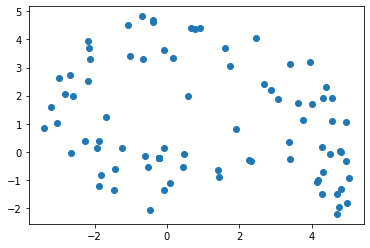

In [16]:
embeddings = model._vq_vae._embedding.weight.data.cpu()
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
y = pca.fit_transform(embeddings)
plt.scatter(y[:,0],y[:,1])
plt.show()

In [17]:
embeddings

tensor([[ 7.0209e-41,  7.0209e-41,  7.0209e-41,  ...,  7.0209e-41,
          7.0209e-41, -7.0209e-41],
        [ 7.0209e-41, -7.0209e-41, -7.0209e-41,  ..., -7.0209e-41,
         -7.0209e-41, -7.0209e-41],
        [-7.0209e-41, -7.0209e-41,  7.0209e-41,  ..., -7.0209e-41,
          7.0209e-41,  7.0209e-41],
        ...,
        [ 7.8871e-01,  1.9195e-01, -4.5106e-01,  ...,  6.7328e-01,
         -5.9341e-01, -7.2493e-01],
        [ 9.0710e-01,  6.5645e-01, -8.6369e-01,  ...,  6.8986e-01,
         -8.7497e-01, -9.0332e-01],
        [-8.9677e-01,  1.0546e-01, -3.6687e-01,  ...,  2.8703e-01,
          5.8321e-01,  2.7874e-01]])

In [18]:
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated1.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated2.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated3.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated4.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated5.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated6.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated7.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated8.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated9.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated10.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated11.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated12.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated13.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated14.wav")
model.load_state_dict(torch.load("model_epoch"+str(args.load), map_location="cuda:0"))
reconstructions = generate(original_wav = './VCTK/wav48/p225/p225_001.wav', speaker = 'p226', filename = "generated15.wav")

45237
1
tensor([146, 154, 152,  ...,  96, 175, 129])
tensor(255) tensor(2)
tensor([ 73, 190, 147,  ..., 106, 142, 151])
tensor(250) tensor(8)


KeyboardInterrupt: 

In [ ]:
model.eval()

original_wav = './VCTK/wav48/p225/p225_002.wav'
speaker_index = speaker_dic['p226']

wav, sr = librosa.load(original_wav)
print(len(wav))
speaker = np.eye(number_of_speakers)[speaker_index]
speaker = torch.tensor(speaker)
speaker = speaker.unsqueeze(0)

normalized = librosa.util.normalize(wav)
quantized = quantize_data(normalized, 256)

max_audio_start = quantized.shape[0] - 16126
if (max_audio_start > 0):
    audio_start = random.randint(0, max_audio_start)
    sample = quantized[audio_start:audio_start+16126]
else :
    sample = np.append(quantized, np.zeros(16126 - len(quantized))).astype(int)

sample = torch.from_numpy(sample)
ohe_audio = torch.FloatTensor(256, 16126).zero_()
ohe_audio.scatter_(0, sample.unsqueeze(0), 1.)

speaker_id = torch.from_numpy(np.array(speaker_index)).unsqueeze(0).unsqueeze(0).long()
ohe_speaker = torch.FloatTensor(number_of_speakers, 1).zero_()
ohe_speaker.scatter_(0, speaker_id, 1.)


valid_originals = ohe_audio.to(device).unsqueeze(0)
speaker_id = ohe_speaker.to(device).unsqueeze(0)

with torch.no_grad():
    encoded = model._encoder(valid_originals)

    _, valid_quantize, _ = model._vq_vae(encoded)
    #valid_reconstructions = model._decoder(valid_originals, valid_quantize, speaker_id) - this one works fine
    valid_reconstructions = model._decoder.incremental_forward(valid_originals[:,:,0:1], 
                                                               valid_quantize, 
                                                               speaker_id, 
                                                               T=16126)

In [ ]:
plt.plot(valid_quantize[:,0,:].detach().cpu().numpy().ravel())
plt.show()

In [ ]:
recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
plt.plot(recon)
plt.show()

In [ ]:
orig = valid_originals.squeeze().argmax(dim=0).detach().cpu().numpy()
#plt.plot(valid_quantize.detach().numpy().ravel())
plt.plot(orig)
plt.show()

In [ ]:
recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
mu_encoded = (recon + 1) / 128 - 1
mu_decoded = mu_law_decode(mu_encoded, mu=256)
plt.plot(mu_decoded[2000:4000])
plt.show()

In [ ]:
recon = valid_originals.squeeze().argmax(dim=0).detach().cpu().numpy()
mu_encoded_orig = (recon + 1) / 128 - 1
mu_decoded_orig = mu_law_decode(mu_encoded_orig, mu=256)
plt.plot(mu_decoded_orig[2000:4000])
plt.show()

In [ ]:
from IPython.display import Audio, display

In [ ]:
display(Audio(mu_decoded, rate=22050))

In [ ]:
display(Audio(mu_decoded_orig, rate=22050))

## View Embedding

In [ ]:
# model.load_state_dict(torch.load("model_epoch"+str(495), map_location="cuda:0"))
# model.load_state_dict(torch.load("mymodel", map_location="cuda:0"))

In [ ]:
embeddings = model._vq_vae._embedding.weight.data.cpu()
#print(embeddings)
#print(embeddings.shape)
embeddings

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
y = pca.fit_transform(embeddings)
plt.scatter(y[:,0],y[:,1])
plt.show()